# <p style="text-align: center;">Création d'un dataset MIL-MNIST pour effectuer de l'apprentissage faiblement supervisé</p>

#### Importation des bibliothèques nécessaire 

In [203]:
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import copy

## Création du dataset

#### Récupération de la base de données MNIST

In [204]:
# On télécharge 2 datasets test et entraiment
transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist_train = MNIST("./data", train=True, transform=transform)
mnist_test = MNIST("./data", train=False, transform=transform)

On transforme les images de nos datasets en vecteur de taille 28x28

In [237]:
def Vectorize_Dataset(datasets):
    data_vect = []


    for image, label in datasets:
        image_flattened = image.view(-1)
        data_vect.append((image_flattened, label))

    vect, lab = zip(*data_vect)

    # Créer des tenseurs à partir des listes
    vect_tensor = torch.stack(vect)
    lab_tensor = torch.tensor(lab)

    # Créer un ensemble de données TensorDataset
    data_vect = torch.utils.data.TensorDataset(vect_tensor, lab_tensor)
    
    return data_vect

In [238]:
mnist_train_vect = Vectorize_Dataset(mnist_train)
mnist_test_vect = Vectorize_Dataset(mnist_test)

Création d'un dataset sans label 1 pour éviter d'avoir que des bags avec le label 1 quand on divisera nos datasets en bag de 64 éléments

In [239]:
class MNISTBagDataset1(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.bags = self.separate_data()

    def __len__(self):
        return len(self.bags)
    
    def __getitem__(self, idx):
        images, labels = self.bags[idx]
        label = labels
        return images, labels
    
    def separate_data(self):
        data_without1 = []
        for i, (image, label) in enumerate(self.mnist_dataset):
            if label != 1:
                current_data = (image, label)
                data_without1.append(current_data)
        return data_without1

In [240]:
mnist_train_dataset_without_one = MNISTBagDataset1(mnist_train_vect)
mnist_test_dataset_without_one = MNISTBagDataset1(mnist_test_vect)

#### Concaténation de 2 datasets MNIST (sans label 1 et avec tous les labels) et division en bag de n éléments

On récupère alors un dataset MNIST d'environ 120 000 éléments avec 2 fois moins de label 1 ce qui va nous permettre d'avoir des bags de label zéro quand on va diviser nos datasets en bags de 64 données.

In [241]:
class MNISTBagDataset(Dataset):
    def __init__(self, mnist_dataset, mnist_dataset1, bag_size):
        self.mnist_dataset = mnist_dataset
        self.mnist_dataset1 = mnist_dataset1
        self.bag_size = bag_size
        self.bags = self.create_bags()

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        images, labels = self.bags[idx]
        # On vérifie la présence du chiffre 1 dans le sac et attribuer le label en conséquence
        label = 1 if 1 in labels else 0
        return images, label
    

    def create_bags(self):
        bags = []
        current_bag = ([], [])  

        # On concatène les deux ensembles de données
        combined_dataset = self.mnist_dataset + self.mnist_dataset1

        for i, (image, label) in enumerate(combined_dataset):
            current_bag[0].append(image)
            current_bag[1].append(label)
            if len(current_bag[0]) == self.bag_size:
                bags.append(current_bag)
                current_bag = ([], [])
        # On ajoute quand même le dernier bag même s'il n'est pas complet
        if current_bag[0]:
            bags.append(current_bag)
        
        return bags

On créer à présent nos 2 data sets (test et entrainement) qui sont divisés en bag de 64 données. On a normalement approximativement autant de bag avec le label 0 et le label 1.

In [242]:
# On choisit le nombre d'élément dans nos bags
bag_length_train = 64
bag_length_test = 64

# On créer un ensemble de données d'entrainement et de tests avec des sacs divisé en bag de n élément
bag_dataset = MNISTBagDataset(mnist_train_vect, mnist_train_dataset_without_one, bag_length_train)
bag_dataset_test = MNISTBagDataset(mnist_test_vect, mnist_test_dataset_without_one, bag_length_test)

On mélange les datasets obtenus 

In [243]:
def shuffleDataset(datasets):
    
    
    indices = list(range(len(datasets)))

    
    random.shuffle(indices)

    dataset_shuffle = []

    for idx in indices:
        images, label = datasets[idx]
        dataset_shuffle.append(datasets[idx])
    
    return dataset_shuffle

Récupération des datasets mélangés

In [244]:
bag_dataset_shuffle = shuffleDataset(bag_dataset)
bag_dataset_test_shuffle = shuffleDataset(bag_dataset_test)

On créer à présent notre ensemble de test et d'entainement avec un nombre de bags défini

In [245]:
# On prend les 100 premiers sacs pour l'ensemble de training et les 50 premiers sacs pour l'ensemble de test
bag_dataset_train_100 = torch.utils.data.Subset(bag_dataset_shuffle, range(100))
bag_dataset_test_50 = torch.utils.data.Subset(bag_dataset_test_shuffle, range(50))

On extrait les features de nos bags et on les moyennent pour obtenir un vecteur features pour chaque bag de données. C'est le vecteur features des bags que nous allons passer dans notre réseau pour l'apprentissage et le test

In [246]:
data_features = []
for image, label in bag_dataset_train_100:
    vecteurs_concatenes = torch.stack(image, dim=0)
    vecteurs_concatenes_moy = torch.mean(vecteurs_concatenes, dim=0)
    data_features.append((vecteurs_concatenes_moy, label))
    
data_features_test = []
for image, label in bag_dataset_test_50:
    vecteurs_concatenes_test = torch.stack(image, dim=0)
    vecteurs_concatenes_moy_test = torch.mean(vecteurs_concatenes_test, dim=0)
    data_features_test.append((vecteurs_concatenes_moy_test, label))

On vérifie que nos deux ensembles test et entrainement on une proportion de label zéro cohérente

In [247]:
compteur_label_zero = 0 
compteur_label_zero_test = 0

for i in range(len(data_features)):
    if data_features[i][1] == 0:
        compteur_label_zero += 1
print('Pour notre train_dataset :')
print('nombre de bags avec label zéro :', compteur_label_zero)
print('taux de bags avec le label zéro :', compteur_label_zero/len(data_features))

for i in range(len(data_features_test)):
    if data_features_test[i][1] == 0:
        compteur_label_zero_test += 1
print('Pour notre test_dataset :')
print('nombre de bags avec label zéro :', compteur_label_zero_test)
print('taux de bags avec le label zéro :', compteur_label_zero_test/len(data_features_test))

Pour notre train_dataset :
nombre de bags avec label zéro : 44
taux de bags avec le label zéro : 0.44
Pour notre test_dataset :
nombre de bags avec label zéro : 21
taux de bags avec le label zéro : 0.42


## Entrainement du réseau

On charge nos deux datasets avec dataloader

In [248]:
bag_dataloader_train = torch.utils.data.DataLoader(data_features, batch_size=25, shuffle=True)
bag_dataloader_test = torch.utils.data.DataLoader(data_features_test, batch_size=25, shuffle=False)

#### Boucle d'entrainement

In [249]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-paramètre du réseau 
num_epochs = 100
learning_rate = 0.001
loss_value = []
iteration = []

# Réseau pleinement-connecté avec une couche cachée
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #x = torch.sigmoid(self.fc3(x))
        return x
    
model = SimpleNN().to(device)

# Loss et optimizer utilisé
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Entrainement du model
n_total_steps = len(bag_dataloader_train)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(bag_dataloader_train):  
        # Transformation des images en vecteur de 28*28 
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Propagation avant
        outputs = model(images)
        labels = labels.unsqueeze(1)
        labels = labels.float()
        loss = criterion(outputs, labels)
        
        # Rétropopagation et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_value.append(loss.item())
            iteration.append(((epoch+1)*n_total_steps)-n_total_steps+i+1)


Epoch [1/100], Step [1/4], Loss: 0.7043
Epoch [1/100], Step [2/4], Loss: 0.6931
Epoch [1/100], Step [3/4], Loss: 0.6927
Epoch [1/100], Step [4/4], Loss: 0.6888
Epoch [2/100], Step [1/4], Loss: 0.6913
Epoch [2/100], Step [2/4], Loss: 0.6993
Epoch [2/100], Step [3/4], Loss: 0.6775
Epoch [2/100], Step [4/4], Loss: 0.6818
Epoch [3/100], Step [1/4], Loss: 0.6811
Epoch [3/100], Step [2/4], Loss: 0.6771
Epoch [3/100], Step [3/4], Loss: 0.6836
Epoch [3/100], Step [4/4], Loss: 0.7051
Epoch [4/100], Step [1/4], Loss: 0.6653
Epoch [4/100], Step [2/4], Loss: 0.7037
Epoch [4/100], Step [3/4], Loss: 0.6606
Epoch [4/100], Step [4/4], Loss: 0.7054
Epoch [5/100], Step [1/4], Loss: 0.6720
Epoch [5/100], Step [2/4], Loss: 0.6825
Epoch [5/100], Step [3/4], Loss: 0.7085
Epoch [5/100], Step [4/4], Loss: 0.6603
Epoch [6/100], Step [1/4], Loss: 0.6547
Epoch [6/100], Step [2/4], Loss: 0.6868
Epoch [6/100], Step [3/4], Loss: 0.6712
Epoch [6/100], Step [4/4], Loss: 0.6988
Epoch [7/100], Step [1/4], Loss: 0.6736


#### Evolution de la perte par rapport au nombres d'itérations

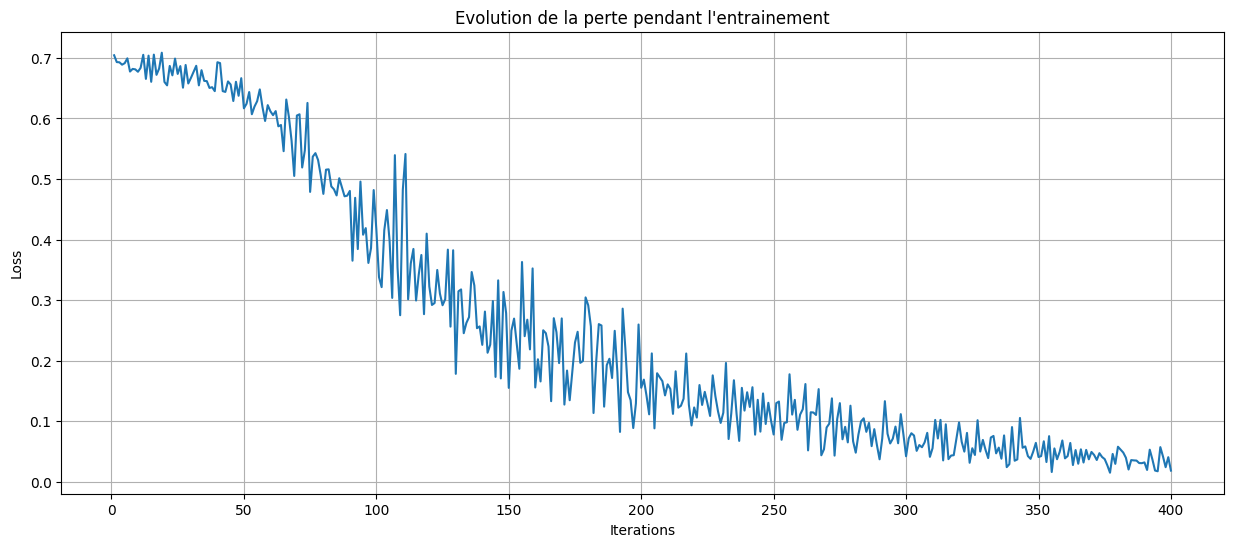

In [250]:
# On trace la courbe de l'évolution de notre perte pendant l'entrainement
plt.figure(figsize=(15, 6))
plt.plot(iteration, loss_value)
plt.title('Evolution de la perte pendant l\'entrainement')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)  
plt.show()

## Test du modèle 

In [251]:
with torch.no_grad():
    n_correct = 0
    n_bags = 0
    for images, labels in bag_dataloader_test:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)


        # Conversion des probabilités en prédictions binaires (0 ou 1)
        predictions = torch.round(probabilities)
        predictions = torch.transpose(predictions, 0, 1)
    
        # Comparaison des prédictions avec les labels pour calculer la précision
        n_correct += (predictions == labels).sum().item()
        n_bags += labels.size(0)

    acc_bags = 100*  n_correct / n_bags
    
    print('Performance du réseau')
    print(f'Précision du réseau pour la prédiction des bags : {acc_bags} %')

Performance du réseau
Précision du réseau pour la prédiction des bags : 84.0 %
